In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12512656.68it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212106.47it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3935651.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24343040.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
# It takes a Dataset and wraps an iterable over it.
# It supports batching, sampling, shuffling, multiprocessing.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


(array([-10.,   0.,  10.,  20.,  30.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30')])

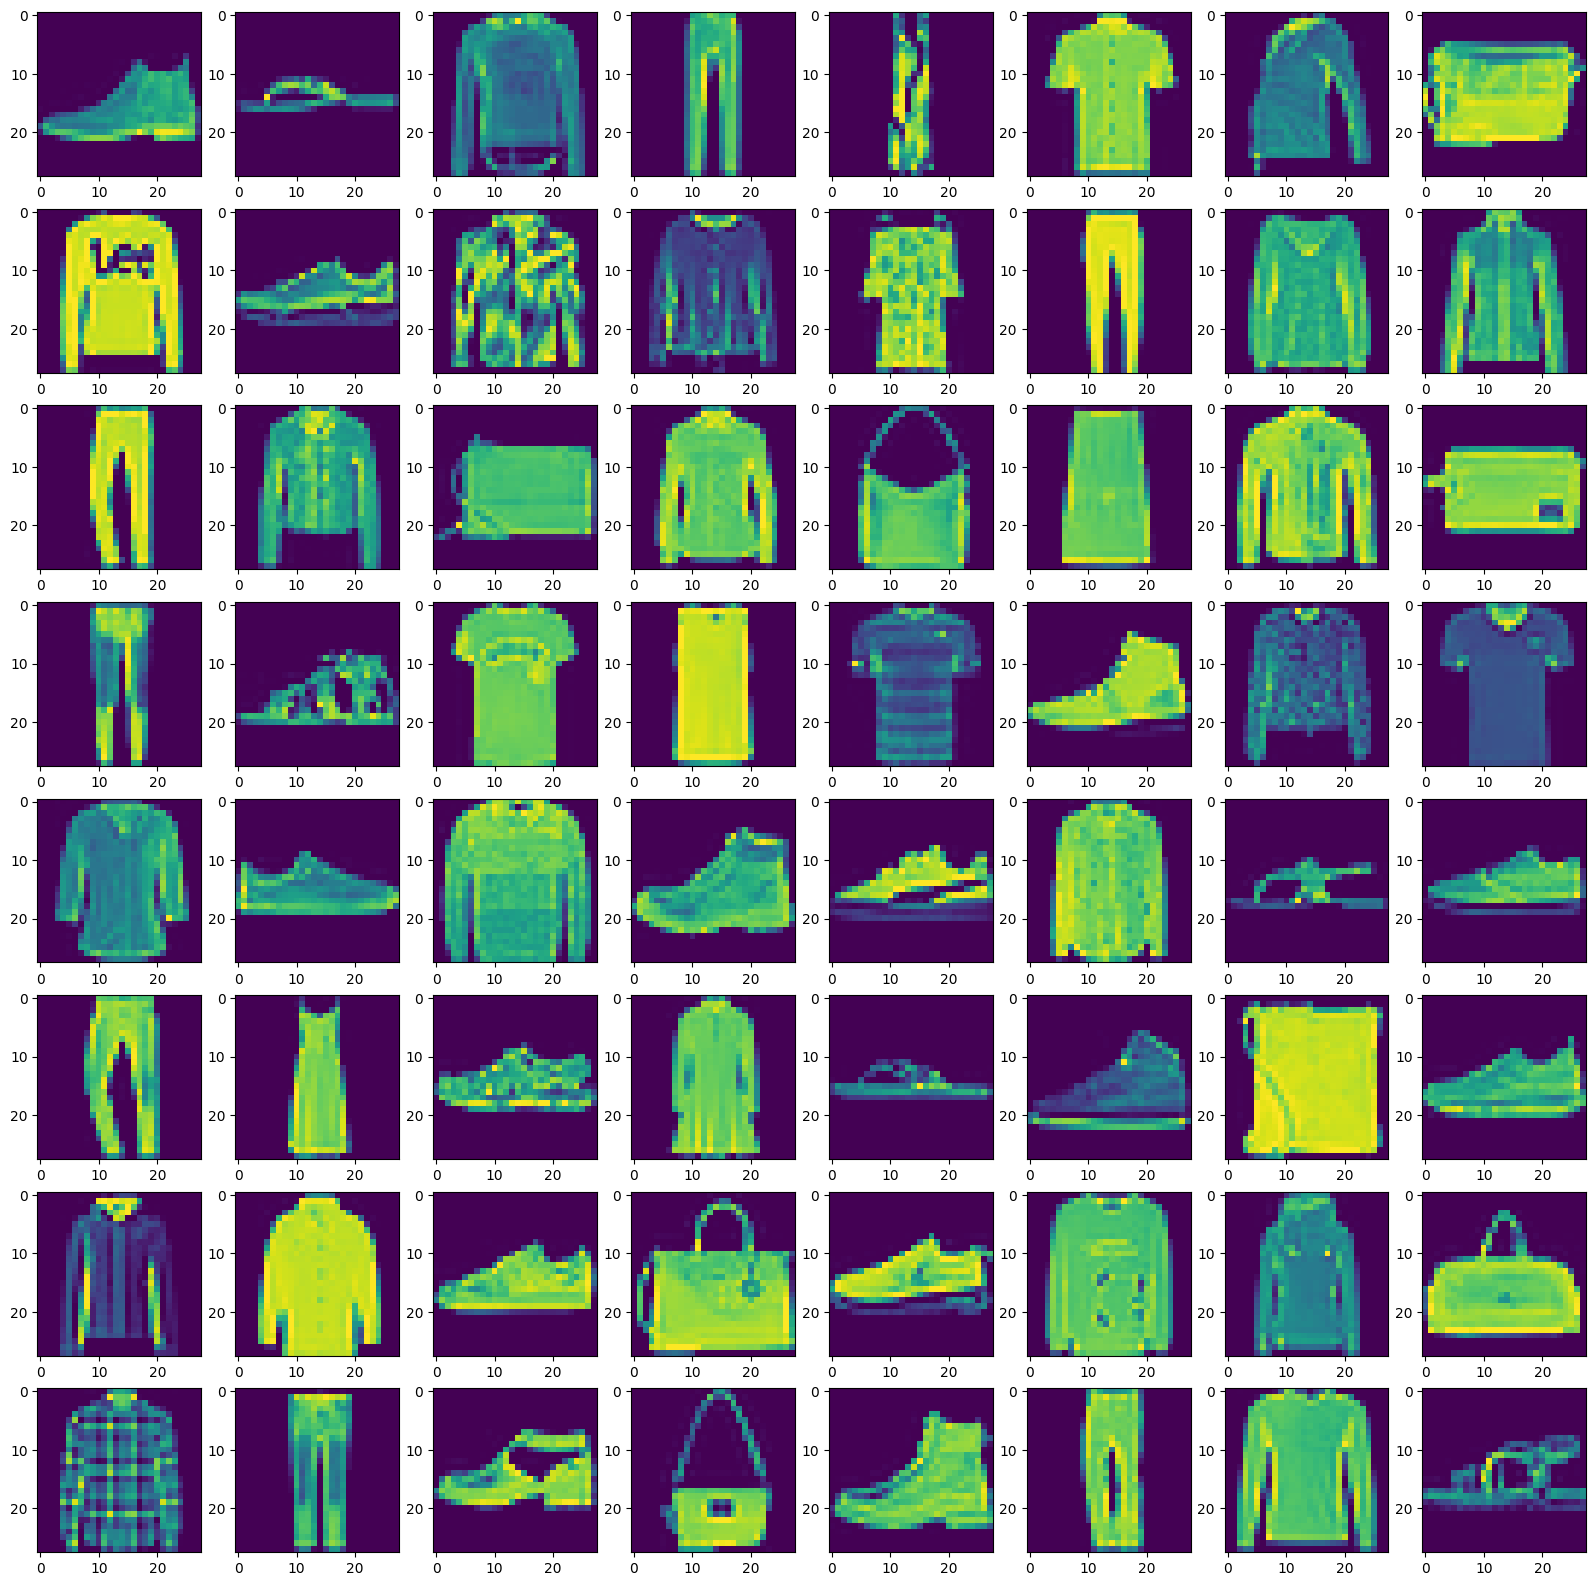

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(8, 8, figsize=(20,20))
for ix, im in enumerate(X):
  x_ix = ix % 8
  y_ix = ix // 8
  axes[x_ix, y_ix].imshow(im.permute(1,2,0))
plt.xticks()
plt.yticks()

## Creating Models

In [5]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

In [6]:
print(f"Using {device} device")

Using cuda device


In [15]:
# Define model
class NeuralNetwork(nn.Module): # inherits nn.Module
  def __init__(self): # define layers in constructor
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x): # specify how data will pass through the network
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device) # move to device (gpu)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

To train a model, we need a loss function and an optimizer.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # for the first argument, pass tensor to optimize.

In [20]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # need this step before backpropagating for the next batch!

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [18]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval() ## turn off dropout, batchnorm, etc.
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct) :>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n -------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
 -------------------
loss: 2.306919 [   64/60000]
loss: 2.296108 [ 6464/60000]
loss: 2.279270 [12864/60000]
loss: 2.270816 [19264/60000]
loss: 2.253212 [25664/60000]
loss: 2.239959 [32064/60000]
loss: 2.234351 [38464/60000]
loss: 2.209883 [44864/60000]
loss: 2.203257 [51264/60000]
loss: 2.177364 [57664/60000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 2.172393 

Epoch 2
 -------------------
loss: 2.176044 [   64/60000]
loss: 2.165679 [ 6464/60000]
loss: 2.119000 [12864/60000]
loss: 2.127233 [19264/60000]
loss: 2.084725 [25664/60000]
loss: 2.043350 [32064/60000]
loss: 2.046839 [38464/60000]
loss: 1.987069 [44864/60000]
loss: 1.984578 [51264/60000]
loss: 1.919530 [57664/60000]
Test Error: 
 Accuracy: 58.2%, Avg loss: 1.917222 

Epoch 3
 -------------------
loss: 1.942318 [   64/60000]
loss: 1.911986 [ 6464/60000]
loss: 1.809772 [12864/60000]
loss: 1.833841 [19264/60000]
loss: 1.738128 [25664/60000]
loss: 1.698248 [32064/60000]
loss: 1.696699 [38464/60000]
loss: 1.616908 [44864/6000

In [22]:
# internal state dictionary contains the model parameters.
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [23]:
model = NeuralNetwork().to(device) # re-creating model structure
model.load_state_dict(torch.load("model.pth")) # loading state dictionary into it.

<All keys matched successfully>

In [25]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()
X, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  X = X.to(device)
  pred = model(X)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
